# Tanford’s Surface Solvation Revisited: Interactions in Caffeine-Salt Solutions
Stefan Hervø-Hansen,<sup>a,*</sup> Jakub Polák,<sup>b,*</sup>Markéta Tomandlová,<sup>b</sup> Joachim Dzubiella,<sup>c</sup>Jan Heyda,<sup>b,*</sup> and Mikael Lund.<sup>a,*</sup>

<sup>a</sup> Division of Theoretical Chemistry, Department of Chemistry, Lund University, Lund SE 221 00, Sweden. <br>
<sup>b</sup> Department of Physical Chemistry, University of Chemistry and Technology, Prague, Technická 5, CZ-16628 Praha 6, Czech Republic. <br>
<sup>c</sup> Physikalisches Institut, Albert-Ludwigs Universität Freiburg, Hermann-Herder-Straße 3, D-79104 Freiburg im Breisgau, Germany.<br><br>
<sup>*</sup>To whom correspondence may be addressed stefan.hervo_hansen@teokem.lu.se; jan.heyda@vscht.cz; mikael.lund@teokem.lu.se

## Introduction
We present a study about the interactions in caffeine-salt solutions using experimental and computational methods. To study highly concentrated systems feasibly, one commonly utilizes implicit solvation methods for the main solvent, which is usually water. Here we take it one step further and include implicit inclusion of salts and salt-specific effects. Inspired by Tanford’s surface solvation model, we construct a Solvent Accessible Surface Area (SASA) Hamiltonian to capture the effects of salt and solvent on the attraction and repulsion of solutes. The general applicability of the model comes via a solvent-salt-solute-dependent Transfer Free Energy (TFE), which modulates the strength of the attraction or repulsion between solute species. 


## Methods & Materials
Metropolis Monte Carlo simulations[<sup>1</sup>](#fn1) were conducted using the Faunus (2.4.2)[<sup>2</sup>](#fn2)[<sup>,3</sup>](#fn3). For the simulation of caffeine in the presence of implicit solvent and salt, our pseudo-SASA pair-potential was employed, which calculates the overlapping surface area between pairs of spherical particles. For the calculation of the excess pressure, the volume perturbation method[<sup>4</sup>](#fn4) was utilized, with isotropic scaling of the periodic box dimensions and centroid of the individual caffeine molecules. For the calculation of the difference in excess chemical potential for caffeine in water and salt solutions, the Widom insertion method[<sup>5</sup>](#fn5) was employed in the canonical ensemble and also obtained using the sampled density in the grand canonical ensemble.


## References
1. <span id="fn1"> N. Metropolis, A. W. Rosenbluth, M. N. Rosenbluth, A. H. Teller, E. Teller, Equation of State Calculations by Fast Computing Machines. The Journal of Chemical Physics 21, 1087–1092 (1953).</span><br>
2. <span id="fn2"> B. Stenqvist, A. Thuresson, A. Kurut, R. Vácha, M. Lund, Faunus– a flexible framework for Monte Carlo simulation. Molecular Simulation 39, 1233–1239 (2013).</span><br>
3. <span id="fn3"> M. Lund, M. Trulsson, B. Persson, Faunus: An object oriented framework for molecular simulation. Source Code Biol Med 3 (2008).</span><br>
4. <span id="fn4"> V. I. Harismiadis, J. Vorholz, A. Z. Panagiotopoulos, Efficient pressure estimation in molecular simulations without evaluating the virial. The Journal of Chemical Physics 105, 8469–8470 (1996).</span><br>
5. <span id="fn5"> B. Widom, Some Topics in the Theory of Fluids. The Journal of Chemical Physics 39, 2808–2812 (1963).</span><br>


## Import modules
_Run this cell only **once** to ensure `homedir` is correctly set!_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import pandas as pd
import jinja2 as jinja
import subprocess
import itertools
import pandas as pd
from IPython.display import Markdown
import scipy
import json
import mdtraj as md
import scipy.stats as stats
import scipy.optimize as optimize

# Physical constants and unit conversion
kJmol_to_kT = 0.40338846309 # @298.15 Kelvin
litre_to_Åcube = 10**(27)   # Ångstrom cubed
RT = 0.00831446261*298.15   # kJ/mol
Na = 6.02214086*10**(23)    # 1/mol

plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

homedir = !pwd
homedir = homedir[0]
print(homedir)

/data2/stefan/SI-caffeine-surface-area


## Overview of the Coarse-graining of Caffeine
<figure>
  <img src=Figures/CFF_CG.png alt="Caffeine coarse graining" style=width:40%>
  <center> <b> Figure 1</b>: Coarse-graining of caffeine (spheres) over the atomic representation of caffeine. The naming of the groups CF1-CF8 can be parameterized individually in the following or in the <code>Templates/</code> directory. </center>
</figure>

## Osmotic Coefficient Calibration
The model calibration has been conducted by searching for a value for the surface tension ($\gamma$) following the coarse-graining scheme previously presented to reproduce the caffeine concentration dependency of the osmotic coefficient. The osmotic coefficient is defined as the ratio between the total pressure of a system and the pressure of an ideal gas at the same concentration and temperature. Mathematically one can write:
$$\varphi = \frac{p^{\text{id}}+p^{\text{ex}}}{p^{\text{id}}} \tag{eq. 1}$$
where $p^{\text{id}}$ is the ideal pressure and $p^{\text{ex}}$ is the excess pressure arising from intermolecular interactions between molecules in the system. To introduce an excluded volume for the coarse grained caffeine atoms we utilize a Weeks-Chandler-Andersen (WCA) potential, while all further attraction and repulsion is introduced though the SASA pair potential. For simplicity the `tension` variable is limited to only affect CF7 and CF8, while CF1-CF6 have their `tension=0`.

### Template loading and simulation setups

In [2]:
%cd -q $homedir
# Template prepration
templateLoader = jinja.FileSystemLoader(searchpath="Templates")
templateEnv = jinja.Environment(loader=templateLoader)
TEMPLATE_FILE = "osmotic_calibration_template.yml"
template = templateEnv.get_template(TEMPLATE_FILE)


# Simulation settings
caffeineConcentrations = np.arange(start=0.005, stop=0.113, step=0.005) # Caffeine concentrage range
equil_steps = 50000                                                     # Number of equilibration MC steps
prod_steps  = 2000000                                                   # number of protection MC steps (x10)
tension     = 0.0548                                                    # Atomic surface tension

### Conducting simulations
The simulations will be conducted by inserting 200 particles and adjusting the volume such that we obtain the desired concentration of caffeine.

In [ ]:
import os
import time
import mdtraj as md
submit_script="""#!/bin/bash
#PBS -l nodes=1:ppn=1:nu               # 1 node, 1 core, CPU node
#PBS -N Caffeine_{conc:.3g} # Job name
#PBS -e run.err            # Error output
#PBS -o run.out            # Output file name

source ~/.bashrc
source ~/.bash_profile

cd {path}
. /data2/APPLI/packages/gcc/gcc-12.1.0.rc

~/faunus/faunus -i Caffeine_calibration.json -v6 --nobar"""

In [ ]:
%cd -q $homedir
numOfSims = 0

# Input parameters for the simulation
jinjaInput = {
'Homedir': '',
'Length': '',
'Steps': '',
'Tension': '',
'SaltConc': '',
'EquilSteps': ''
}

for caffeineConcentration in caffeineConcentrations:
    %cd -q $homedir
    # Calculate box size
    boxLength = np.around(np.cbrt(200 * Na**(-1) / float(caffeineConcentration) * litre_to_Åcube))

    # Input parameters into templeate
    jinjaInput['Homedir'] = homedir
    jinjaInput['Length'] = boxLength
    jinjaInput['Steps'] = equil_steps + prod_steps
    jinjaInput['EquilSteps'] = equil_steps
    jinjaInput['Tension'] = tension
    jinjaInput['SaltConc'] = 0
    outputText = template.render(jinjaInput)

    # Write faunus input file
    filePath = "Simulations/osmoticCalibration/{0:.3g}/Caffeine_calibration.yml".format(caffeineConcentration)
    folderPath =  "Simulations/osmoticCalibration/{0:.3g}".format(caffeineConcentration)
    ymlFile = open(filePath, "w")
    ymlFile.write(outputText)
    ymlFile.close()
    !chmod u+x $filePath
    %cd -q $folderPath
    !python /home/stefan/faunus/scripts/yason.py Caffeine_calibration.yml > Caffeine_calibration.json
    
    with open('submit.pbs', 'w') as text_file:
        text_file.write(submit_script.format(path=os.getcwd(), conc=caffeineConcentration))
    text_file.close()
    !qsub submit.pbs
    time.sleep(1) # Safety in submission of jobs: can cause problems if too fast
    
    #subprocess.call(['screen','-d','-m', 'nice', 'faunus', '-v6', '-i', 'Caffeine_calibration.json'])
    numOfSims += 1

print('Number of simulations submitted: {}'.format(numOfSims))

### Visualizing the calibration

/home/stefan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


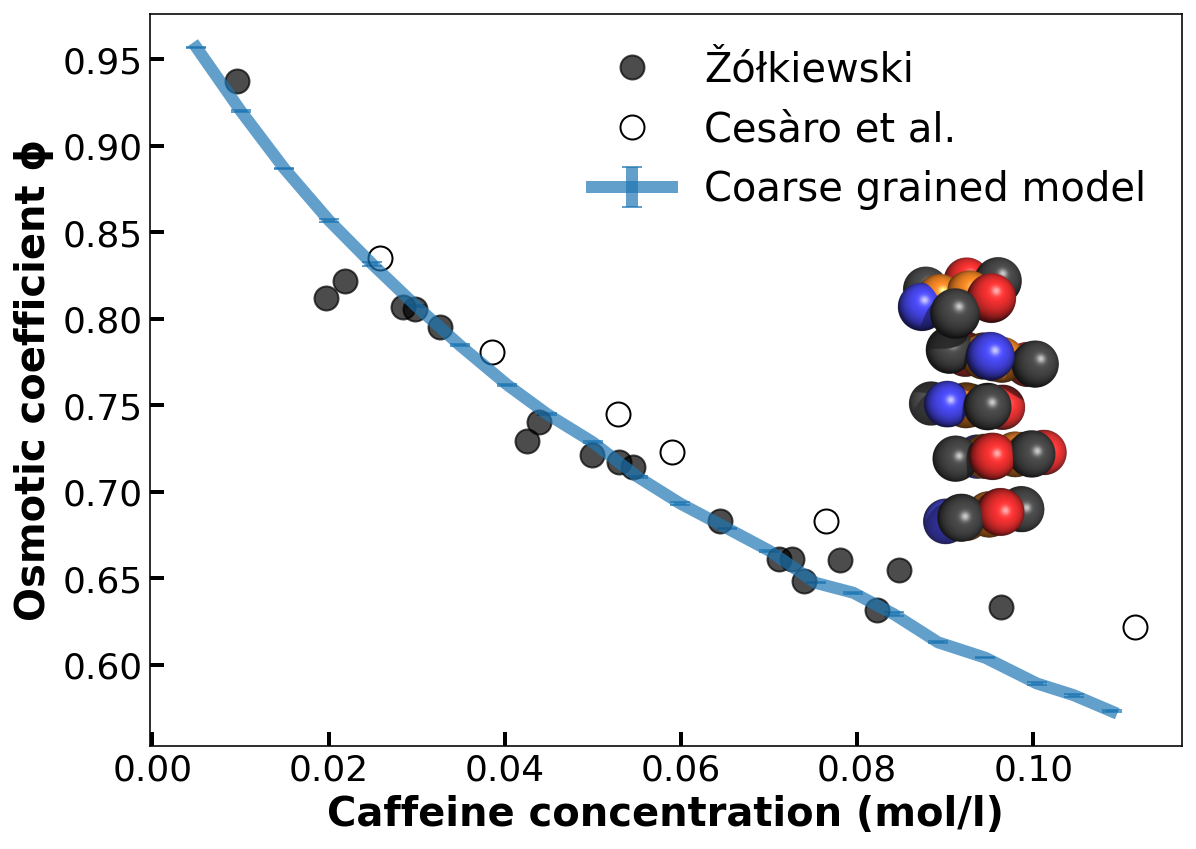

In [68]:
#### EXPERIMENTAL DATA ####
# https://doi.org/10.1007/BF00652586 (Žółkiewski)
conc_exp1 = [0.0096, 0.0197, 0.0219, 0.0285, 0.0298, 0.0327, 0.0425, 0.0439, 0.0499,
            0.0530, 0.0546, 0.0644, 0.0711, 0.0726, 0.0740, 0.0780, 0.0823, 0.0848, 0.0963]
osm_exp1 = [0.9375, 0.8122, 0.8219, 0.8070, 0.8054, 0.7951, 0.7294, 0.7403, 0.7214,         # (25.0 °C)
           0.7169, 0.7143, 0.6832, 0.6610, 0.6611, 0.6486, 0.6603, 0.6318, 0.6545, 0.6334]  # (25.0 °C)

# https://pubs.acs.org/doi/pdf/10.1021/j100544a026 (Cesàro et al.)
conc_exp2 = [0.1116, 0.0765, 0.0590, 0.0528, 0.0386, 0.0258] # (29.8 °C)
osm_exp2  = [0.622,  0.683,  0.723,  0.745,  0.781,  0.835]  # (29.8 °C)
conc_exp3 = [0.1027, 0.0895, 0.0702, 0.0509, 0.0296, 0.0203] # (35.0 °C)
osm_exp3  = [0.656,  0.680,  0.720,  0.755,  0.837,  0.877]  # (35.0 °C)
###########################

INSERT = True # Choose to do insert

%cd -q $homedir
fig = plt.figure(figsize=(8.4,6))
ax = fig.add_subplot(111)

Clist = []              # Concentrations
Ocoefficient_list = []  # Mean of mean osmotic coefficients
Ocoefficient_error = [] # Standard deviations of mean osmotic coefficients

for caffeineConcentration in caffeineConcentrations:
    with open ('Simulations/osmoticCalibration/{0:.3g}/out.json'.format(caffeineConcentration)) as json_file:
        data = json.load(json_file)
    pid = data['analysis'][0]['molecule_density']['densities']['CFF1']['c/M'] * Na / litre_to_Åcube
        
    dV = 5              # Volume perturbation in cubic Ångstrom
    Boltzmann_factor = np.loadtxt("Simulations/osmoticCalibration/{0:.3g}/volume.dat".format(caffeineConcentration), unpack=True, usecols=(3), skiprows=1)
    Boltzmann_factor = np.reshape(Boltzmann_factor, (-1, 4)).mean(axis=0) # Averaging over 4 equal blocks.
    pex = np.log(Boltzmann_factor)/dV

    osmoticCoeffificent = (pid+pex)/pid
    
    Ocoefficient_list.append(osmoticCoeffificent.mean())
    Ocoefficient_error.append(osmoticCoeffificent.std())
    Clist.append(data['analysis'][0]['molecule_density']['densities']['CFF1']['c/M'])

# Plot simulation data
ax.errorbar(Clist, Ocoefficient_list, yerr=Ocoefficient_error, linestyle='solid', linewidth=6,
            label='Coarse grained model', alpha=0.7, capsize=5)    
        
# plot experimental sets
ax.plot(conc_exp1, osm_exp1, 'ko', label='Žółkiewski', ms=12, alpha=0.7)
ax.plot(conc_exp2, osm_exp2, 'ko', label='Cesàro et al.', markerfacecolor='none', ms=12)

if INSERT:
    ax_insert = fig.add_axes([.64, .35, .35, .35]) # Construct embedded axis
    img = mpimg.imread('Figures/Caffeine_Configuration.png')
    ax_insert.imshow(img)
    ax_insert.spines['right'].set_visible(False)
    ax_insert.spines['top'].set_visible(False)
    ax_insert.spines['bottom'].set_visible(False)
    ax_insert.spines['left'].set_visible(False)
    ax_insert.tick_params(axis='both', labelbottom=False, top=False, left=False, right=False, bottom=False, labelleft=False)
    ax_insert.patch.set_alpha(0.01)

# Sets labels and limits
ax.set_xlabel(r'Caffeine concentration (mol/l)', weight='bold',  size=20)
ax.set_ylabel(r'Osmotic coefficient ϕ', weight='bold', size=20)

# Sets axes ticks
ax.minorticks_off()
ax.tick_params(which='both', width=2, direction='in')
ax.tick_params(which='major', length=7, direction='in')
ax.tick_params(which='minor', length=3, direction='in')
for tick in list(itertools.chain(*[ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()])):
    tick.label.set_fontsize(18)
    
# Legend
ax.legend(loc='best', fontsize=20, frameon=False)

fig.tight_layout()
fig.savefig('Figures/Osmotic_coefficient.pdf', bbox_inches='tight')

## Comparing the True SASA and Pseudo SASA

In [35]:
def getPseudoSasa(traj, radii, probe_radius=0.13, precompute_distances=True):
    '''
    Calculate the total surface area of two overlapping spheres
    '''
    sasa = np.zeros(shape=(traj.n_frames))
    if precompute_distances:                                                           # Calculate distance matrix for trajectory
        pairs = traj.topology.select_pairs(selection1='all', selection2='all')
        distances = md.compute_distances(traj, pairs, periodic=True, opt=True)
    
    for idx, frame in enumerate(traj):
        A = 0  # Initialize by setting surface area to 0.
        distance_idx = 0                                                               # Initialize distance index
        if precompute_distances == False:                                              # Calculate distance matrix for frame
            pairs = traj.topology.select_pairs(selection1='all', selection2='all')     # Generate pair matrix
            distances = md.compute_distances(frame, pairs, periodic=True, opt=True)[0] # compute 1d distance array for all atoms
        
        for i in range(traj.n_atoms):
            for j in range(traj.n_atoms):
                if j > i:
                    R = radii[traj.topology.atom(i).name] + probe_radius
                    r = radii[traj.topology.atom(j).name] + probe_radius
                    if precompute_distances:
                        d = distances[idx][distance_idx]
                    else:
                        d = distances[distance_idx]
                    # Eq. 6 in the paper
                    if (d <= R - r):
                        A += 4*np.pi*R**2
                    elif (R-r < d) and (d < R+r):
                        h1 = (r-R+d)*(r+R-d)/(2*d)
                        h2 = (R-r+d)*(R+r-d)/(2*d)
                        A += 4*np.pi*(R**2 + r**2) - 2*np.pi*(R*h1+r*h2)
                    elif d >= R+r:
                        A += 4*np.pi*(R**2+r**2)
                    else:
                        raise Exception('Spheres does not obay any of the conditions listed in Eq. 6')
                    distance_idx +=1 # Increment distance index by one for next iteration

        sasa[idx] = A
    
    return sasa

In [36]:
CG_radii = { # Radii used for the pseudo calculation
    'CF1': 0.5*0.306,
    'CF2': 0.5*0.306,
    'CF3': 0.5*0.306,
    'CF4': 0.5*0.312,
    'CF5': 0.5*0.312,
    'CF6': 0.5*0.372,
    'CF7': 0.5*0.464,
    'CF8': 0.5*0.418
         }

CG_symbol_radii = { # radii used for the Shrake-Rupley algorithm
    'H' : 0.5*0.306,
    'He': 0.5*0.306,
    'Li': 0.5*0.306,
    'Be': 0.5*0.312,
    'B' : 0.5*0.312,
    'C' : 0.5*0.372,
    'N' : 0.5*0.464,
    'O' : 0.5*0.418
         }

traj = md.load_xtc('Simulations/osmoticCalibration/0.11/trajectory.xtc',
                   top='Structures/Topology.pdb')

frames = traj[0:-1:500]
pseudo_sasa = getPseudoSasa(frames, CG_radii, probe_radius=0.13, precompute_distances=True)
sasa = md.shrake_rupley(frames, mode='residue', change_radii=CG_symbol_radii)

Linear statistics:
Slope: 3.347 ± 0.128.
Intercept: 12.713 ± 1.936 Å².
Adjusted R²: 0.6250
p-value: 3.766533e-89


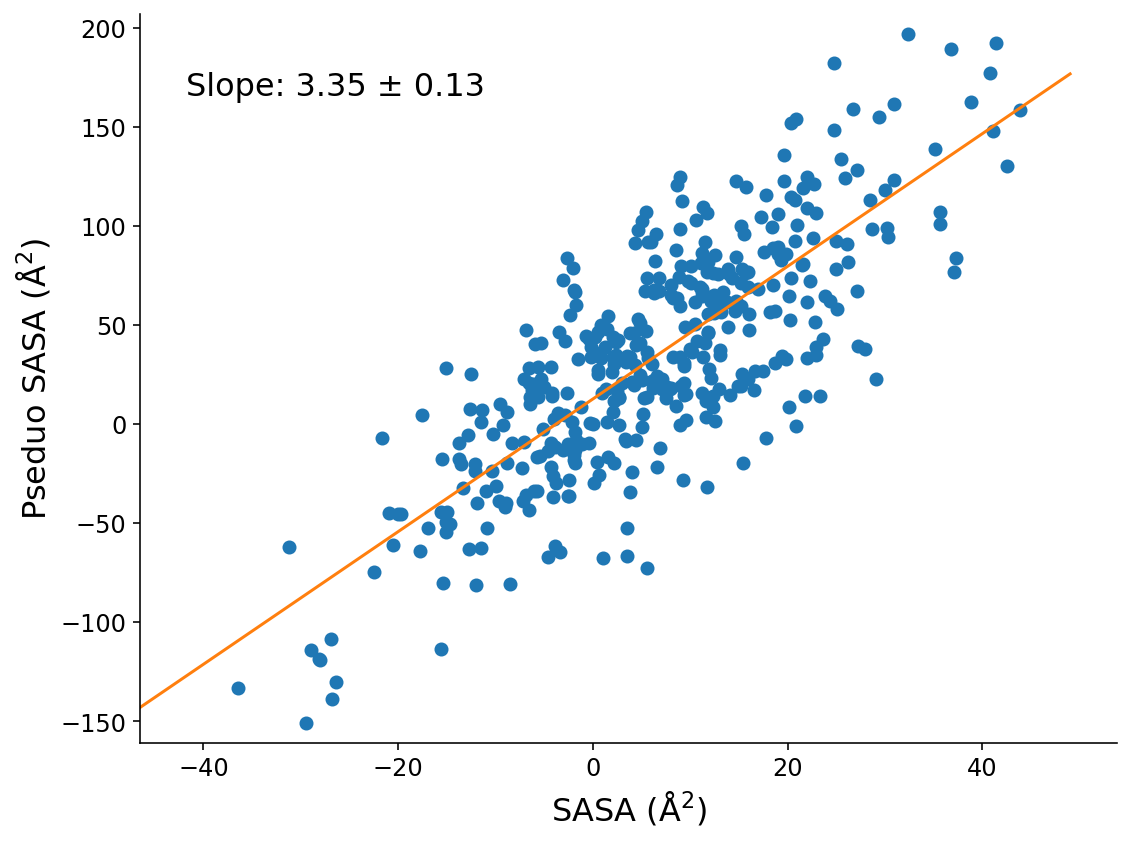

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(sasa.sum(axis=1)-sasa.sum(axis=1)[0], pseudo_sasa-pseudo_sasa[0], marker='o', linewidth=0)

# Linear regression
s = stats.linregress(sasa.sum(axis=1)-sasa.sum(axis=1)[0], pseudo_sasa-pseudo_sasa[0])
adjusted_r2 = 1 - ( (1-s.rvalue**2) * (len(frames)-1) / (len(frames)-2-1))
print('Linear statistics:\nSlope: {:.3f} ± {:.3f}.\nIntercept: {:.3f} ± {:.3f} Å².\nAdjusted R²: {:.4f}\np-value: {:e}'.format(s.slope, s.stderr, s.intercept, s.intercept_stderr, adjusted_r2, s.pvalue))
ax.plot(np.arange(-50, 50, 1), np.arange(-50, 50, 1)*s.slope+s.intercept)
ax.text(0.20, 0.9, 'Slope: {:.2f} ± {:.2f}'.format(s.slope, s.stderr), fontsize=16, 
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

ax.set_xlim(min(sasa.sum(axis=1)-sasa.sum(axis=1)[0])-10, max(sasa.sum(axis=1)-sasa.sum(axis=1)[0])+10)
ax.set_ylim(min(pseudo_sasa-pseudo_sasa[0])-10, max(pseudo_sasa-pseudo_sasa[0])+10)

ax.set_xlabel('SASA (Å$^2$)', fontsize=16)
ax.set_ylabel('Pseduo SASA (Å$^2$)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
fig.savefig('Figures/SASA_comparison.pdf', bbox_inches='tight')

## Pseudo SASA Potential Energy Function

In [2]:
def pseudoSASAEnergy(d, sigma1=1.0, sigma2=1.0, probe_radius=1.3, tfe1=0, tfe2=0, gamma1=0, gamma2=0,
                     salt_concentration=0, epsilon1=1.0, epsilon2=1.0, decomposed=False, shifted=True):
    gamma = (gamma1+gamma2)/2
    tfe   = (tfe1+tfe2/2)/2
    
    def getPseudoSASA(d=d, radius1=sigma1/2, radius2=sigma2/2, probe_radius=probe_radius):
        R = max((radius1 + probe_radius, radius2 + probe_radius))
        r = min(radius1 + probe_radius, radius2 + probe_radius)
        
        # Eq. 6 in the paper
        if d <= R - r:
            A = 4*np.pi*R**2
        elif (R-r < d) and (d < R+r):
            h1 = (r-R+d)*(r+R-d)/(2*d)
            h2 = (R-r+d)*(R+r-d)/(2*d)
            A = 4*np.pi*(R**2 + r**2) - 2*np.pi*(R*h1+r*h2)
        elif d >= R+r:
            A = 4*np.pi*(R**2+r**2)
        else:
            raise Exception('Spheres does not obay any of the conditions listed in Eq. 6')
            
        return A
    
    def getWCAEnergy(d=d, sigma1=sigma1, sigma2=sigma2, epsilon1=epsilon1, epsilon2=epsilon2):
        sigma = (sigma1+sigma2)/2
        epsilon = np.sqrt(epsilon1*epsilon2)
        if d >= 2**(1/6)*sigma:
            return 0
        else:
            LJ = 4 * epsilon * ( (sigma/d)**12 - (sigma/d)**6 )
            LJ += epsilon
            return LJ
        
    A = getPseudoSASA()
    WCA = getWCAEnergy()

    # Eq. 9 in paper
    if shifted:
        A_seperation = getPseudoSASA(np.inf, radius1=sigma1/2, radius2=sigma2/2, probe_radius=probe_radius)
        shift_energy = A_seperation*(gamma + salt_concentration*tfe)
        U = WCA + A*(gamma + salt_concentration*tfe) - shift_energy
        salt_term = A*(gamma + salt_concentration*tfe) - shift_energy
    else:
        U = WCA + A*(gamma + salt_concentration*tfe)
        salt_term = A*(gamma + salt_concentration*tfe)

    if decomposed:
        return (U, WCA, salt_term)
    else:
        return U

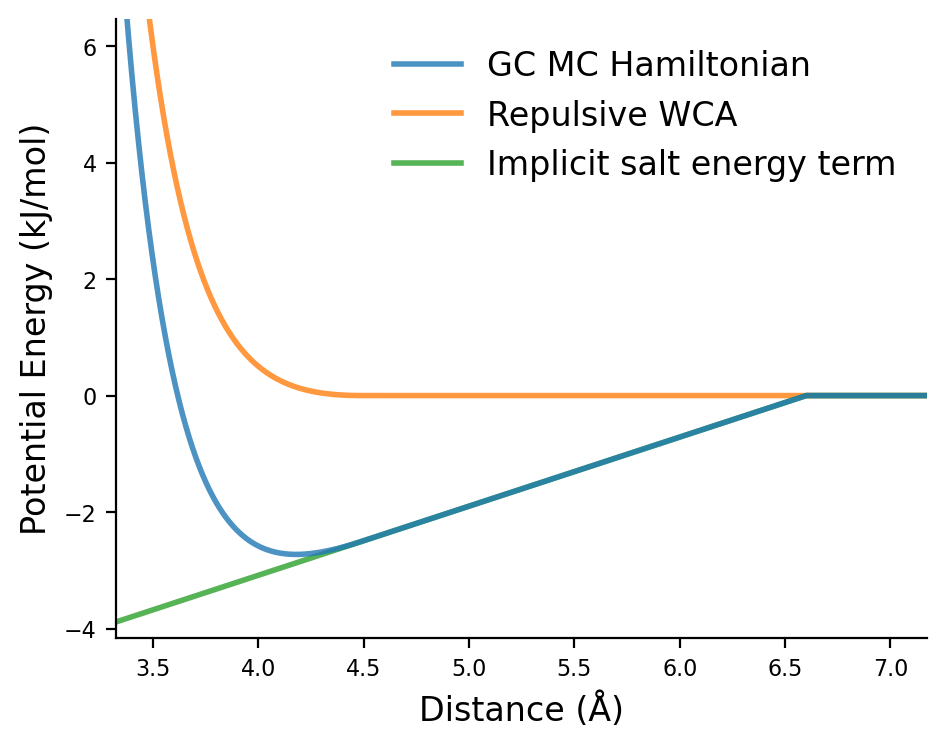

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

distances = np.arange(3.0, 8, 0.001)
U         = np.zeros(shape=(len(distances)))
WCA       = np.zeros(shape=(len(distances)))
salt_term = np.zeros(shape=(len(distances)))

for i, distance in enumerate(distances):
    U[i], WCA[i], salt_term[i] = pseudoSASAEnergy(distance, sigma1=4.0, sigma2=4.0, probe_radius=1.3, gamma1=0.0572, 
                                                   gamma2=0.0572, epsilon1=0.5, epsilon2=0.5, decomposed=True, shifted=True)
    
ax.plot(distances, U, label='GC MC Hamiltonian', linewidth=2, zorder=10, alpha=0.8)
ax.plot(distances, WCA, label='Repulsive WCA', linewidth=2, alpha=0.8)
ax.plot(distances, salt_term, label='Implicit salt energy term', linewidth=2, alpha=0.8)



ax.set_xlabel('Distance (Å)', fontsize=12)
ax.set_ylabel('Potential Energy (kJ/mol)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=0, frameon=0, fontsize=12)
ax.set_xlim(3.325, 7.174)
ax.set_ylim(-4.159, 6.456)

fig.tight_layout()
fig.savefig('Figures/GC_MC_Potential_Decomposition.pdf', bbox_inches='tight')

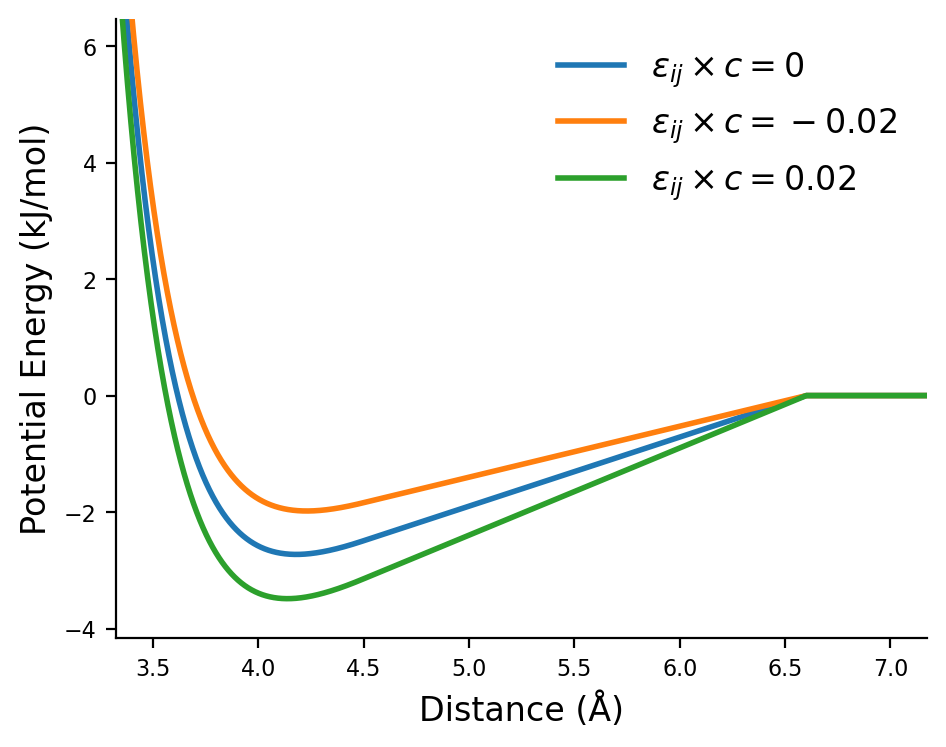

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

distances = np.arange(3.0, 8, 0.001)
U         = np.zeros(shape=(3, len(distances)))


for i, tfe in enumerate([0, -0.02, 0.02]):
    for j, distance in enumerate(distances):
        U[i][j] = pseudoSASAEnergy(distance, sigma1=4.0, sigma2=4.0, probe_radius=1.3, gamma1=0.0572, 
                                gamma2=0.0572, epsilon1=0.5, epsilon2=0.5, decomposed=False, shifted=True,
                                tfe1=tfe, tfe2=tfe, salt_concentration=1.0)
    
    ax.plot(distances,U[i], label=r'$\varepsilon_{{ij}}\times c = {}$'.format(tfe), color='C{}'.format(i), linewidth=2)

ax.set_xlabel('Distance (Å)', fontsize=12)
ax.set_ylabel('Potential Energy (kJ/mol)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=0, frameon=0, fontsize=12)
ax.set_xlim(3.325, 7.174)
ax.set_ylim(-4.159, 6.456)

fig.tight_layout()
fig.savefig('Figures/GC_MC_Potential_Salt.pdf', bbox_inches='tight')

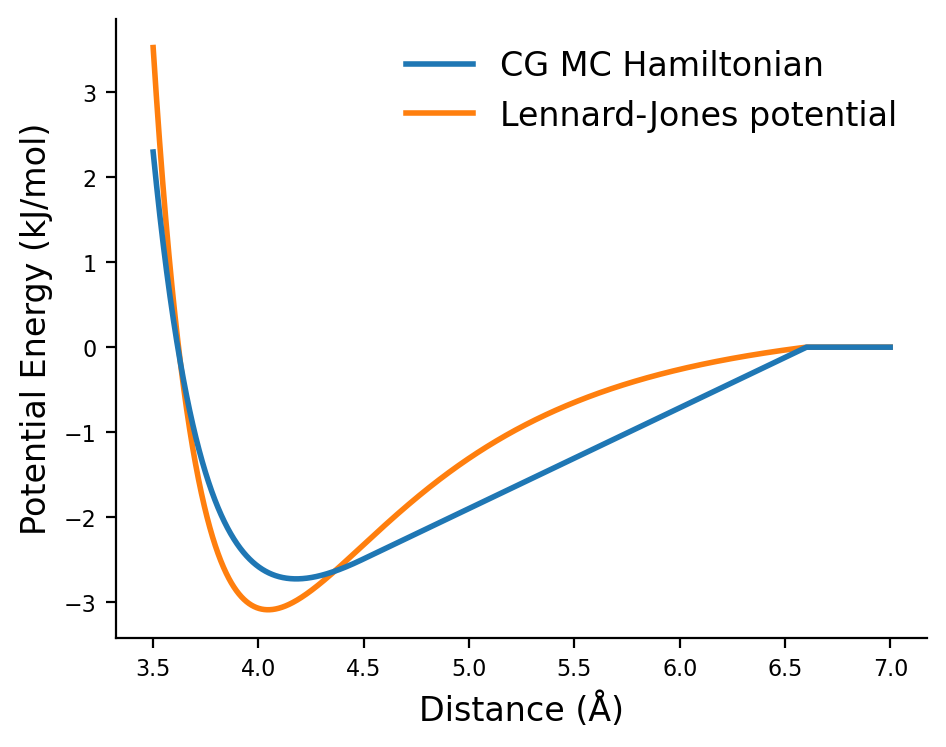

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

distances = np.arange(3.5, 7, 0.001)
energies = np.zeros(shape=(len(distances)))

for i, distance in enumerate(distances):
    energies[i] = pseudoSASAEnergy(distance, sigma1=4.0, sigma2=4.0, probe_radius=1.3,
                                   gamma1=0.0572, gamma2=0.0572, epsilon1=0.5, epsilon2=0.5)

def LJ_truncated_and_shifted(x, eps, sig):
    offset = 4 * eps * ( (sig/6.6)**12 - (sig/6.6)**6 )
    U = np.where(x >= 6.6,
            0,
            4 * eps * ( (sig/x)**12 - (sig/x)**6 ) - offset)
    return U


opt_LJ = optimize.curve_fit(LJ_truncated_and_shifted, distances, energies)[0]


ax.plot(distances, energies, label='CG MC Hamiltonian', linewidth=2, zorder=2)
ax.plot(distances, LJ_truncated_and_shifted(distances, opt_LJ[0], opt_LJ[1]),
        label='Lennard-Jones potential',linewidth=2, zorder=1)

ax.set_xlabel('Distance (Å)', fontsize=12)
ax.set_ylabel('Potential Energy (kJ/mol)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc=0, frameon=0, fontsize=12)

fig.tight_layout()
fig.savefig('Figures/GC_MC_Potential_vs_LJ.pdf', bbox_inches='tight')

## Osmotic Coefficient Calibration: Behavior of the Parameter Space
It could be seen from the previous calibration that using `tension = 0.0548` yielded a too strong attraction at higher concentrations of caffeine. To make a more robust model at higher concentrations of caffeine and investigate the behavior of the parameter space on the curvature of the osmotic coefficient with the caffeine concentration we now introduce more parameters to our model. In specific we introduce the variables `tension_ring` and `tension_methyl`. `tension_ring` like the previous `tension` variable accounts for the surface tension on CF7 and CF8, while `tension_methyl` accounts for the surface tension on CF1, CF2, and CF3, being the methyl groups of caffeine.
### Template loading and simulation setups

In [ ]:
%cd -q $homedir
# Template prepration
templateLoader = jinja.FileSystemLoader(searchpath="Templates")
templateEnv = jinja.Environment(loader=templateLoader)
TEMPLATE_FILE = "osmotic_calibration_alternative_template.yml"
template = templateEnv.get_template(TEMPLATE_FILE)


# Simulation settings (shared parameters)
caffeineConcentrations = np.arange(start=0.005, stop=0.113, step=0.005) # Caffeine concentrage range
equil_steps = 50000                                                     # Number of equilibration MC steps
prod_steps  = 2000000                                                   # number of protection MC steps (x10)

# Model specific parameters
model1 = {'Name': 'Alternative_model_1', 'Tension_ring': 0.0480, 'Tension_methyl':  0.0100}
model2 = {'Name': 'Alternative_model_2', 'Tension_ring': 0.0660, 'Tension_methyl': -0.0200}
models = [model1, model2]

### Conduct simulations
The simulations will be conducted by inserting 200 particles and adjusting the volume such that we obtain the desired concentration of caffeine.

In [ ]:
%cd -q $homedir
numOfSims = 0

# Input parameters for the simulation
jinjaInput = {
'Homedir': ''
'Length': '',
'Steps': '',
'Tension_ring': '',
'Tension_methyl': '',
'SaltConc': '',
'EquilSteps': ''
}

for caffeineConcentration in caffeineConcentrations:
    # Calculate box size
    boxLength = np.around(np.cbrt(200 * Na**(-1) / float(caffeineConcentration) * litre_to_Åcube))
    for model in models:
        # Input parameters into templeate
        jinjaInput['Homedir'] = homedir
        jinjaInput['Length'] = boxLength
        jinjaInput['Steps'] = equil_steps + prod_steps
        jinjaInput['EquilSteps'] = equil_steps
        jinjaInput['Tension_ring'] = model['Tension_ring']
        jinjaInput['Tension_methyl'] = model['Tension_methyl]
        jinjaInput['SaltConc'] = 0
        outputText = template.render(jinjaInput)

        # Write faunus input file
        filePath = "Simulations/osmoticCalibration_{0}/{1:.3g}/Caffeine_calibration.yml".format(model['name'], caffeineConcentration)
        folderPath =  "Simulations/osmoticCalibration_{0}/{1:.3g}".format(model['name'], caffeineConcentration)
        ymlFile = open(filePath, "w")
        ymlFile.write(outputText)
        ymlFile.close()
        !chmod u+x $filePath
        %cd -q $folderPath
        !./Caffeine_calibration.yml > Caffeine_calibration.json
        subprocess.call(['screen','-d','-m', 'nice', 'faunus', '-v6', '-i', 'Caffeine_calibration.json'])
        numOfSims += 1

print('Number of simulations submitted: {}'.format(numOfSims))

### Visualizing the alternative calibrations

In [ ]:
#### EXPERIMENTAL DATA ####
# https://doi.org/10.1007/BF00652586 (Žółkiewski)
conc_exp1 = [0.0096, 0.0197, 0.0219, 0.0285, 0.0298, 0.0327, 0.0425, 0.0439, 0.0499,
            0.0530, 0.0546, 0.0644, 0.0711, 0.0726, 0.0740, 0.0780, 0.0823, 0.0848, 0.0963]
osm_exp1 = [0.9375, 0.8122, 0.8219, 0.8070, 0.8054, 0.7951, 0.7294, 0.7403, 0.7214,         # (25.0 °C)
           0.7169, 0.7143, 0.6832, 0.6610, 0.6611, 0.6486, 0.6603, 0.6318, 0.6545, 0.6334]  # (25.0 °C)

# https://pubs.acs.org/doi/pdf/10.1021/j100544a026 (Cesàro et al.)
conc_exp2 = [0.1116, 0.0765, 0.0590, 0.0528, 0.0386, 0.0258] # (29.8 °C)
osm_exp2  = [0.622,  0.683,  0.723,  0.745,  0.781,  0.835]  # (29.8 °C)
conc_exp3 = [0.1027, 0.0895, 0.0702, 0.0509, 0.0296, 0.0203] # (35.0 °C)
osm_exp3  = [0.656,  0.680,  0.720,  0.755,  0.837,  0.877]  # (35.0 °C)
###########################

%cd -q $homedir
fig = plt.figure(figsize=(8.4,6))
ax = fig.add_subplot(111)

# Model specific parameters
model1 = {'Path profix': '', 'Label': 'Original model'}
model2 = {'Path profix': 'Alternative_model_1', 'Label': 'Alternative model'}
model3 = {'Path profix': 'Alternative_model_2', 'Label': 'Alternative model 2'}
models = [model1, model2, model3]

for model in models:
    Clist = []              # Concentrations
    Ocoefficient_list = []  # Mean of mean osmotic coefficients
    Ocoefficient_error = [] # Standard deviations of mean osmotic coefficients
    
    for caffeineConcentration in caffeineConcentrations:
        with open ('Simulations/osmoticCalibration{0}/{1:.3g}/out.json'.format(model['Path profix'], caffeineConcentration)) as json_file:
            data = json.load(json_file)
        pid = data['analysis'][0]['density']['molecular']['CFF1']['c/M'] * Na / litre_to_Åcube
            
        dV = 5              # Volume perturbation in cubic Ångstrom
        Boltzmann_factor = np.loadtxt("Simulations/osmoticCalibration{0}/{1:.3g}/volume.dat".format(model['Path profix'],caffeineConcentration), unpack=True, usecols=(3), skiprows=1)
        Boltzmann_factor = np.reshape(Boltzmann_factor, (-1, 4)).mean(axis=0) # Averaging over 4 equal blocks.
        pex = np.log(Boltzmann_factor)/dV
    
        osmoticCoeffificent = (pid+pex)/pid
        
        Ocoefficient_list.append(osmoticCoeffificent.mean())
        Ocoefficient_error.append(osmoticCoeffificent.std())
        Clist.append(data['analysis'][0]['density']['molecular']['CFF1']['c/M'])
    
    # Plot simulation data
    ax.errorbar(Clist, Ocoefficient_list, yerr=Ocoefficient_error, linestyle='solid', linewidth=6,
                label=model['Label'], alpha=0.7, capsize=5)    
        
# plot experimental sets
ax.plot(conc_exp1, osm_exp1, 'ko', label='Žółkiewski', ms=12, alpha=0.7)
ax.plot(conc_exp2, osm_exp2, 'ko', label='Cesàro et al.', markerfacecolor='none', ms=12)

# Sets labels and limits
ax.set_xlabel(r'Caffeine concentration (mol/l)', weight='bold',  size=20)
ax.set_ylabel(r'Osmotic coefficient ϕ', weight='bold', size=20)

# Sets axes ticks
ax.minorticks_off()
ax.tick_params(which='both', width=2, direction='in')
ax.tick_params(which='major', length=7, direction='in')
ax.tick_params(which='minor', length=3, direction='in')
for tick in list(itertools.chain(*[ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()])):
    tick.label.set_fontsize(18)
    
# Legend
ax.legend(loc='best', fontsize=20, frameon=False)

fig.tight_layout()
fig.savefig('Figures/Osmotic_coefficient_alternatives.pdf', bbox_inches='tight')

## Transfer Free Energy Calibration to Model Salt-Specific Effects
To incorporate salt-specific effects into our model, we now have to search for transfer free energies (TFE, $\varepsilon_i$) values for the caffeine motifs, which can reproduce the change in excess chemical potential of caffeine going from pure water as a solvent to as salt solution with a finite concentration of salt ($\Delta \mu^{\mathrm{excess}}(C_{s})$). The excess chemical potential, at constant caffeine activity, is obtained by simulations in the grand canonical ensemble ($\mu VT$) as the logarithmic ratio between the chosen activity and the sampled mean density. Mathematically one may write
$$
\Delta \mu^{\mathrm{excess}}(C_{s}) = \mu^{\mathrm{excess}}(C_{s}) - \mu^{\mathrm{excess}}(0) = kT \left[  \ln\left(\frac{a}{\rho(C_{s})}\right) - \ln\left(\frac{a}{\rho(0)}\right) \right] = kT \ln \left(\frac{\rho(0)}{\rho(C_s)}\right) \tag{eq. 2}
$$
Thus the difference in chemical potential is simply given as the logarithmic ratio between the sampled densities for caffeine in pure water and electrolyte solution containing $C_{s}$ molar salt.

### Template loading and simulation setups
Based on the previous, our simulation strategy will be to fixate the caffeine activity and conduct simulations at various salt concentrations and TFE values.

In [ ]:
%cd -q $homedir
# Template prepration
templateLoader = jinja.FileSystemLoader(searchpath="Templates")
templateEnv = jinja.Environment(loader=templateLoader)
TEMPLATE_FILE = "TFE_calibration_template.yml"
template = templateEnv.get_template(TEMPLATE_FILE)

# Simulation settings
salt_concentration_list = [0.1, 0.2, 0.3, 0.4, 0.5]
caffine_activity = 0.026
tfe_list = [-0.0125, -0.008, -0.001, 0.003, 0.0178]
equil_steps = 50000                                                     # Number of equilibration MC steps
prod_steps  = 2000000                                                   # number of protection MC steps (x10)
box_length  = 150                                                       # Legnth of cubic box in Ångstrom

### Conduct simulations

In [ ]:
%cd -q $homedir
numOfSims = 0

# Input parameters for the simulation
jinjaInput = {
'Homedir': ''
'Length': '',
'Steps': '',
'CaffeineActivity': '',
'TFE': '',
'SaltConc': '',
'SelfEnergy': '',
'EquilSteps': ''
}

# Do a single calculation for pure water outside loop
# Input parameters into templeate
jinjaInput['Homedir'] = homedir
jinjaInput['Length'] = box_length
jinjaInput['Steps'] = equil_steps + prod_steps
jinjaInput['CaffeineActivity'] = caffine_activity
jinjaInput['TFE'] = 0
jinjaInput['SaltConc'] = 0
jinjaInput['SelfEnergy'] = 0
outputText = template.render(jinjaInput)

# Write faunus input file
filePath = "Simulations/TFECalibration/{}_{}_{}/TFE_calibration.yml".format(caffine_activity, salt_concentration, tfe)
folderPath =  "Simulations/TFECalibration/{}_{}_{}/".format(caffine_activity, salt_concentration, tfe)
ymlFile = open(filePath, "w")
ymlFile.write(outputText)
ymlFile.close()
!chmod u+x $filePath
%cd -q $folderPath
!./TFE_calibration.yml > TFE_calibration.json
subprocess.call(['screen','-d','-m', 'nice', 'faunus', '-v6', '-i', 'TFE_calibration.json'])
numOfSims += 1


for salt_concentration in salt_concentration_list:
    for tfe in tfe_list:
        # Input parameters into templeate
        jinjaInput['Homedir'] = homedir
        jinjaInput['Length'] = box_length
        jinjaInput['Steps'] = equil_steps + prod_steps
        jinjaInput['CaffeineActivity'] = caffine_activity
        jinjaInput['TFE'] = tfe
        jinjaInput['SaltConc'] = salt_concentration
        jinjaInput['SelfEnergy'] = ((salt_concentration*tfe*4*np.pi*(4.64/2 + 1.3)**2 * 0.40338846309)+ # CF7
                                    (salt_concentration*tfe*4*np.pi*(4.18/2 + 1.3)**2 * 0.40338846309)) # CF8
        outputText = template.render(jinjaInput)

        # Write faunus input file
        filePath = "Simulations/TFECalibration/{}_{}_{}/TFE_calibration.yml".format(caffine_activity, salt_concentration, tfe)
        folderPath =  "Simulations/TFECalibration/{}_{}_{}/".format(caffine_activity, salt_concentration, tfe)
        ymlFile = open(filePath, "w")
        ymlFile.write(outputText)
        ymlFile.close()
        !chmod u+x $filePath
        %cd -q $folderPath
        !./TFE_calibration.yml > TFE_calibration.json
        subprocess.call(['screen','-d','-m', 'nice', 'faunus', '-v6', '-i', 'TFE_calibration.json'])
        numOfSims += 1

print('Number of simulations submitted: {}'.format(numOfSims))

### Visualizing the TFE calibrations

In [ ]:
%cd -q $homedir

# Experimental data
exp_data = pd.read_csv('chem_pot_experimental.csv', header=None, skiprows=2)
exp_data.loc[-1] = [0 for i in range(len(exp_data.columns))] # adding row of 0s
exp_data.index = exp_data.index + 1 # shifting index
exp_data = exp_data.sort_index() # sorting by index

# Simulation settings
salt_concentration_list = [0.1, 0.2, 0.3, 0.4, 0.5]
tfe_list = [-0.0125, -0.008, -0.001, 0.003, 0.0178]

fig, ax = plt.subplots(figsize=(8,5))

labels = ['Na₂SO₄', 'Sucrose' ,'NaCl', 'NaBr', 'NaSCN', 'NaClO₄']
def fitting_func(x, a):
    return a * x

j = 0
for i in range(len(exp_data.columns)):
    if i == 2:
        continue
    if (i % 2) == 0: # a even number check
        ax.plot(exp_data[i], exp_data[i+1], alpha=1.0, color='C{}'.format(j), marker='o', markerfacecolor='none', linestyle='none', markersize=8)
              
        popt, pcov = scipy.optimize.curve_fit(fitting_func, exp_data[i].dropna(), exp_data[i+1].dropna())
        
        # Calculating R**2 value:
        residuals = exp_data[i+1].dropna() - fitting_func(exp_data[i].dropna(), popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((exp_data[i+1].dropna()-np.mean(exp_data[i+1].dropna()))**2)
        r_squared = 1 - (ss_res / ss_tot)
        print('R² value for {cosolute}: \t{rvalue}'.format(cosolute=labels[int(i/2)], rvalue=r_squared))
        
        x = np.arange(0, 1.0, 0.0001)
        y = popt * x
        ax.plot(x, y, color='C{}'.format(j), linestyle='solid', marker='None', alpha=0.50, lw=5)
        
        j += 1
    else:
        continue


# Caffeine in water
%cd -q $homedir
with open ('Simulations/TFECalibration/{}_0_0/out.json'.format(caffine_activity)) as json_file:
    data = json.load(json_file)
    c_caffeine_wat = data['analysis'][0]['density']['molecular']['CFF1']['c/M']

# Caffeine in salt solutions
mu_list = [0]
C_list = [0]
for concentration in concentration_list: 
    for tfe in tfe_list:
        if tfe == 0.0178 and (concentration == 0.5 or concentration == 0.4):
            continue
        conc = '{0:.4f}'.format(concentration)
        folder = str(conc)+'_'+str(tfe)+'_'+str((float(conc)*float(tfe)))
        with open ('Simulations/TFECalibration/{}_{}_{}'.format(caffine_activity, salt_concentration, tfe)) as json_file:
            data = json.load(json_file)
            c_caffeine_salt = data['analysis'][0]['density']['molecular']['CFF1']['c/M']
            mu_excess = np.log(c_caffeine_wat/c_caffeine_salt)     # Eq 2
            mu_list.append(mu_excess)
            C_list.append(concentration)

ax.scatter(C_list, mu_list, s=50, color='black')


## BEAUTIFICATION ##
# Sets labels and limits
ax.set_xlabel(r'Salt concentration (mol/l)', weight='bold',  size=16)
ax.set_ylabel(r'Excess Chem. Pot. (kT)', weight='bold', size=16)

# Sets axes ticks
#ax.minorticks_on()
ax.tick_params(which='both', width=2, direction='in')
ax.tick_params(which='major', length=7, direction='in')
ax.tick_params(which='minor', length=3, direction='in')
for tick in list(itertools.chain(*[ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()])):
    tick.label.set_fontsize(14)
    
# Axis limits
ax.set_xlim(0, 0.6)
ax.set_ylim(-0.8, 1)

# Legend
custom_lines = [matplotlib.lines.Line2D([0], [0], color='black', linestyle='None', marker='o', markerfacecolor='none', markersize=8),
                matplotlib.lines.Line2D([0], [0], color='black', linestyle='solid', marker='None', lw=5),
                matplotlib.lines.Line2D([0], [0], color='black', linestyle='None', marker='o', markersize=8)]
ax.legend(custom_lines, ['Exprimental data', 'Experiment fit (linear)', 'Monte Carlo'], fontsize=20, frameon=False)
## END OF BEAUTIFICATION ##

fig.tight_layout()
%cd -q $homedir
fig.savefig('Figures/Chem_pot_exp_v_sim.pdf', bbox_inches='tight')

## Decomposition of Difference in Chemical Potential for Caffeine into One-body and Many-Body Effects.
The obtained excess chemical potentials from the grand canonical simulations can be decomposed into the contribution arising from caffeine's interaction with the solvent and salt (one-body) and the contribution arising from caffeine's interaction with other caffeine molecules (many-body). Within our model, the one-body contribution can be calculated analytically, and assuming the excess chemical potential can be expressed as a linear combination of the two contributions we obtain:
$$
\Delta \mu^{\text{ex}} = \Delta \mu^{\text{ex}}_{\text{Caffeine-caffeine}} + \Delta \mu^{\text{ex}}_{\text{Caffeine-solution}}
$$
### Template loading and simulation setups

In [ ]:
%cd -q $homedir
# Template prepration
templateLoader = jinja.FileSystemLoader(searchpath="Templates")
templateEnv = jinja.Environment(loader=templateLoader)
TEMPLATE_FILE = "TFE_calibration_template.yml"
template = templateEnv.get_template(TEMPLATE_FILE)

# Simulation settings
salt_concentration_list = [0.1, 0.2, 0.3, 0.4, 0.5]
caffine_activity_list = [0.026, 0.013, 0.0065]
tfe_list = [-0.008, 0.008]
equil_steps = 50000                                                     # Number of equilibration MC steps
prod_steps  = 2000000                                                   # number of protection MC steps (x10)
box_length  = 150      

### Conduct simulations

In [ ]:
%cd -q $homedir
numOfSims = 0

# Input parameters for the simulation
jinjaInput = {
'Homedir': ''
'Length': '',
'Steps': '',
'CaffeineActivity': '',
'TFE': '',
'SaltConc': '',
'SelfEnergy': '',
'EquilSteps': ''
}


# Do a single calculation for pure water in a seperate loop
for caffine_activity in caffine_activity_list:
    # Input parameters into templeate
    jinjaInput['Homedir'] = homedir
    jinjaInput['Length'] = box_length
    jinjaInput['Steps'] = equil_steps + prod_steps
    jinjaInput['CaffeineActivity'] = caffine_activity
    jinjaInput['TFE'] = 0
    jinjaInput['SaltConc'] = 0
    jinjaInput['SelfEnergy'] = 0
    outputText = template.render(jinjaInput)
    
    # Write faunus input file
    filePath = "Simulations/TFESimulations/{}_0_0/TFE_calibration.yml".format(caffine_activity)
    folderPath =  "Simulations/TFESimulations{}_0_0/".format(caffine_activity)
    ymlFile = open(filePath, "w")
    ymlFile.write(outputText)
    ymlFile.close()
    !chmod u+x $filePath
    %cd -q $folderPath
    !./TFE_calibration.yml > TFE_calibration.json
    subprocess.call(['screen','-d','-m', 'nice', 'faunus', '-v6', '-i', 'TFE_calibration.json'])
    numOfSims += 1


for caffine_activity in caffine_activity_list:
    for salt_concentration in salt_concentration_list:
        for tfe in tfe_list:
            # Input parameters into templeate
            jinjaInput['Homedir'] = homedir
            jinjaInput['Length'] = box_length
            jinjaInput['Steps'] = equil_steps + prod_steps
            jinjaInput['CaffeineActivity'] = caffine_activity
            jinjaInput['TFE'] = tfe
            jinjaInput['SaltConc'] = salt_concentration
            jinjaInput['SelfEnergy'] = ((salt_concentration*tfe*4*np.pi*(4.64/2 + 1.3)**2 * 0.40338846309)+ …
                                        (salt_concentration*tfe*4*np.pi*(4.18/2 + 1.3)**2 * 0.40338846309)) # CF8
            outputText = template.render(jinjaInput)

            # Write faunus input file
            filePath = "Simulations/TFESimulations/{}_{}_{}/TFE_calibration.yml".format(caffine_activity, salt_concentration, tfe)
            folderPath =  "Simulations/TFESimulations/{}_{}_{}/".format(caffine_activity, salt_concentration, tfe)
            ymlFile = open(filePath, "w")
            ymlFile.write(outputText)
            ymlFile.close()
            !chmod u+x $filePath
            %cd -q $folderPath
            !./TFE_calibration.yml > TFE_calibration.json
            subprocess.call(['screen','-d','-m', 'nice', 'faunus', '-v6', '-i', 'TFE_calibration.json'])
            numOfSims += 1

print('Number of simulations submitted: {}'.format(numOfSims))

### Visualizing the data

In [ ]:
%cd -q $homedir
# Initialize figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16.8,6))

# Figure 1.
# Loop over finite concentrations where we need MC simulations
for i, caffeine_activity in enumerate(caffine_activity_list):
    # Caffeine in pure water
    with open('Simulations/TFESimulations/{}_0_0/out.json'.format(caffine_activity)) as json_file:
        data = json.load(json_file)
        c_caffeine_wat = data['analysis'][0]['density']['molecular']['CFF1']['c/M']    

    for tfe in tfe_list:
        mu_list = [0.0]
        Csalt   = [0.0]
        for salt_concentration in salt_concentration_list:
            with open('Simulations/TFESimulations/{}_{}_{}/out.json'.format(caffine_activity, salt_concentration, tfe)) as json_file:
                data = json.load(json_file)
                c_caffeine_salt = data['analysis'][0]['density']['molecular']['CFF1']['c/M']'
                mu_excess = np.log(c_caffeine_wat/c_caffeine_salt)
                mu_list.append(mu_excess)
                Csalt.append(concentration)
                
        if tfe < 0:
            label = '{:.1f} mM'.format(activity)
        else:
            label = None
        
        axes[0].plot(Csalt, np.exp(mu_list), label=label, linewidth=3, marker='o', color='C{}'.format(i))

# Loop over infinite dilusion where we can do analytical calculations
for tfe in tfe_list:
    mu_list = [ ]
    Csalt = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    for C in Csalt:
        mu_list.append(((concentration*tfe*4*np.pi*(4.64/2 + 1.3)**2 * 0.40338846309)+  # CF7
                        (concentration*tfe*4*np.pi*(4.18/2 + 1.3)**2 * 0.40338846309))) # CF8
        
    if tfe < 0:
        label = '{:.1f} mM'.format(activity)
    else:
        label = None
    
    axes[0].plot(Csalt, np.exp(mu_list), label=label, linewidth=3, color='C{}'.format(i+1))
    
    
# Figure 2.
caffeine_activity = 0.026
# Caffeine in pure water
with open('Simulations/TFESimulations/{}_0_0/out.json'.format(caffine_activity)) as json_file:
    data = json.load(json_file)
    c_caffeine_wat = data['analysis'][0]['density']['molecular']['CFF1']['c/M']  

for tfe in tfe_list:
    mu_excess_list = [0]
    mu_self_list   = [0]
    Csalt           = [0]
    for salt_concentration in salt_concentration_list:
        with open('Simulations/TFESimulations/{}_{}_{}/out.json'.format(caffine_activity, salt_concentration, tfe)) as json_file:
            data = json.load(json_file)
            c_caffeine_salt = data['analysis'][0]['density']['molecular']['CFF1']['c/M']'
            mu_excess_list.append(np.log(c_caffeine_wat/c_caffeine_salt))
            mu_self_list.append(((concentration*tfe*4*np.pi*(4.64/2 + 1.3)**2 * 0.40338846309)+ # CF7
                                (concentration*tfe*4*np.pi*(4.18/2 + 1.3)**2 * 0.40338846309))) # CF8
            Csalt.append(concentration)
    
    axes[1].plot(C_list, mu_list, 'o-', color='C0', lw=3)
    axes[1].plot(C_list, mu_self, 'o--', color='C0', linestyle='dashed', marker='o', lw=3) 
    axes[1].plot(C_list, np.asarray(mu_list)-np.asarray(mu_self), linestyle='dotted', marker='o', color='C0', lw=3)


## BEAUTIFICATION ##
for ax in axes:
    axes[1].tick_params(which='both', width=2, direction='in')
    axes[1].tick_params(which='major', length=7, direction='in')
    axes[1].tick_params(which='minor', length=3, direction='in')
    for tick in list(itertools.chain(*[axes[1].xaxis.get_major_ticks(), axes[1].yaxis.get_major_ticks()])):
        tick.label.set_fontsize(14)

axes[0].set_xlabel(r'Salt concentration (mol/l)', weight='bold',  size=20)
axes[0].set_ylabel(r'Activity coeffificent γ', weight='bold', size=20)
axes[0].hlines(1, 0, 1.1, color='black', linestyle='dashed', alpha=0.5)
axes[0].text(0.4, 1.0*0.96, '{:15}{:>16}'.format('↓Salting in', '(TFE = -0.008)'), horizontalalignment='left', verticalalignment='center', fontsize=14)
axes[0].text(0.4, 1.0*1.04, '{:15}{:>15}'.format('↑Salting out', '(TFE =  0.008)'), horizontalalignment='left', verticalalignment='center', fontsize=14)
legend = axes[0].legend(loc=2, fontsize=18, frameon=False, title='Caffeine activity')
legend.get_title().set_fontsize(20)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='C7', linestyle='solid', marker='o', lw=3),
                Line2D([0], [0], color='C7', linestyle='dashed', marker='o', lw=3),
                Line2D([0], [0], color='C7', linestyle='dotted', marker='o', lw=3)]
axes[1].legend(custom_lines, ['Total', 'Caffeine-cosolute', 'Caffeine-caffeine'], frameon=False, fontsize=20)
axes[1].set_xlabel(r'Salt concentration (mol/l)', weight='bold',  size=16)
axes[1].set_ylabel(r'Excess Chem. Pot. (kT)', weight='bold', size=16)


fig.tight_layout()
%cd -q $homedir
fig.savefig('Figures/activity_coefficient.pdf')

## Monte Carlo Data for Kirkwood-Buff Inversion
To completely recover the thermodynamics of aqueous caffeine-salt solutions on the grounds of KB theory, we utilize the excess chemical potential contribution arising from the interactions between caffeine species in the solution. To calculate the chemical potential at a fixed concentration of caffeine, we simulate caffeine in the canonical ensemble with the Widom insertion method.

### Template loading and simulation setups

In [ ]:
%cd -q $homedir
# Templeate prepration
templateLoader = jinja.FileSystemLoader(searchpath="Templates")
templateEnv = jinja.Environment(loader=templateLoader)
TEMPLATE_FILE = "TFE_ProductExcessSearch.yml"
template = templateEnv.get_template(TEMPLATE_FILE)

# Simulation settings
equil_steps = 50000                                            # Number of equilibration MC steps
prod_steps  = 1000000                                          # number of protection MC steps
tension     = 0.0548                                           # Atomic surface tension

TFE_list = [-0.01, 0.01]
CSalt_list = [0.0, 0.5, 1.0]                                   # Salt molarity range
CCaffeine_list = [0.1, 0.05, 0.025, 0.0125]
Replica = 3

### Conduct simulations

In [ ]:
numOfSims = 0
for transferEnergy in TFE_list:
    for saltConcentration in CSalt_list:
        for Ccaffeine in CCaffeine_list:
            for replica in range(Replica):
                %cd -q $workdir
                # Input parameters for the simulation with default values
                jinjaInput = {
                'Steps': '',
                'EquilSteps': '',
                'Tension': '',
                'TransferEnergy'
                'SaltConc': '',
                'CaffeineConc': '',
                }
                
                # Input parameters into templeate
                jinjaInput['Steps'] = equil_steps + prod_steps
                jinjaInput['EquilSteps'] = equil_steps
                jinjaInput['Tension'] = tension
                jinjaInput['TransferEnergy'] = transferEnergy
                jinjaInput['SaltConc'] = saltConcentration
                jinjaInput['CaffeineConc'] = Ccaffeine
                outputText = template.render(jinjaInput)
        
                # Write faunus input file
                filePath = "ProductExcessSearch/{}_{}_{}_{}/Caffeine_TFE_search.yml".format(saltConcentration, transferEnergy, Ccaffeine, replica)
                folderPath =  "ProductExcessSearch/{}_{}_{}_{}".format(saltConcentration, transferEnergy, Ccaffeine, replica)
                ymlFile = open(filePath, "w")
                ymlFile.write(outputText)
                ymlFile.close()
                !chmod u+x $filePath
                %cd -q $folderPath
                !./Caffeine_TFE_search.yml > Caffeine_TFE_search.json
                subprocess.call(['screen','-d','-m', 'nice', 'faunus', '-v6', '-i', 'Caffeine_TFE_search.json'])
                numOfSims += 1

print('Number of simulations submitted: {}'.format(numOfSims))

### Writing table

In [ ]:
%cd -q $workdir
TFE_list = [-0.01, 0.01]
CSalt_list = [0.0, 0.5, 1.0]
CCaffeine_list = [0.1, 0.05, 0.025, 0.0125]
Replica = 3


print('Caffine Concentration | Salt Concentration | TFE value | Mean Excess Chemical Potential | Interaction contribution | Solvation contribution')

for transferEnergy in TFE_list:
    for i, Ccaffeine in enumerate(CCaffeine_list):
        for saltConcentration in CSalt_list:
            samples = []
            for replica in range(Replica):
                with open ("TFE_calibration/{}_{}_{}_{}/out.json".format(saltConcentration, transferEnergy, Ccaffeine, replica)) as json_file:
                    data = json.load(json_file)
                
                SelfEnergy = ((saltConcentration*transferEnergy*4*np.pi*(4.64/2 + 1.3)**2 * 0.40338846309)+ # CF7
                              (saltConcentration*transferEnergy*4*np.pi*(4.18/2 + 1.3)**2 * 0.40338846309)) # CF8
                samples.append(data['analysis'][3]['widom']['μ/kT']['excess']+constant)

            samples = np.asarray(samples)
            
            print('{} {} {}: {} ± {}, {}, {}'.format(Ccaffeine, saltConcentration, transferEnergy,
                                                samples.mean(), samples.std()/np.sqrt(Replica), samples.mean()-constant, constant))
            
            plt.errorbar(saltConcentration, samples.mean(), yerr=samples.std()/np.sqrt(Replica), marker='o', color='C{}'.format(i))